/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 
 
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD





def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD

torch.Size([10000, 1056]) torch.Size([10000, 1056]) torch.Size([10000, 1056]) torch.Size([10000, 3])


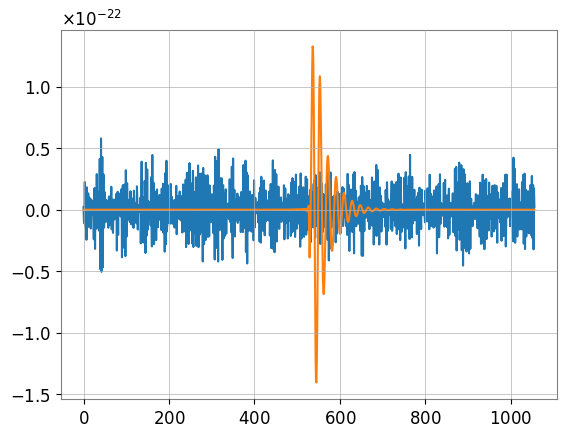

In [ ]:
signal_length=Config.signal_length


data = np.load('data/signal_data_with_noise_SNR5.npz')
#data = np.load('data/test_signal_data.npz')
signals = data['signals']
noises = data['noises']
datas= data['datas']
conditions = data['conditions']
signals= torch.tensor(signals).float()
noises= torch.tensor(noises).float()
datas= torch.tensor(datas).float()
conditions= torch.tensor(conditions).float()
print(signals.shape,noises.shape,datas.shape,conditions.shape)
#绘制一个信号和噪声的例子
import matplotlib.pyplot as plt
import numpy as np
plt.plot(noises[0], label='Noise')
plt.plot(signals[0], label='Signal')

plt.show()

[ True  True  True ...  True  True  True]


/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)


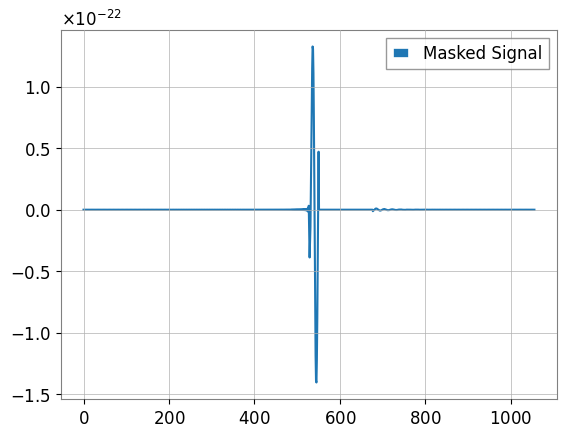

[ True  True  True ...  True  True  True]


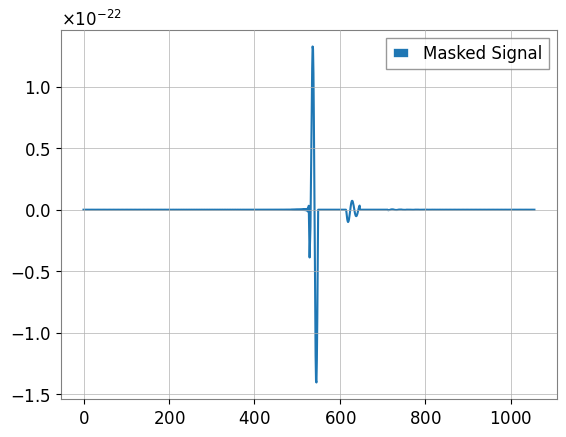

[ True  True  True ...  True  True  True]


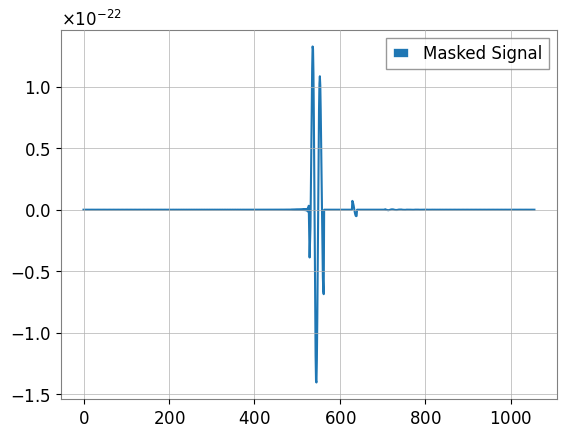

[ True  True  True ...  True  True  True]


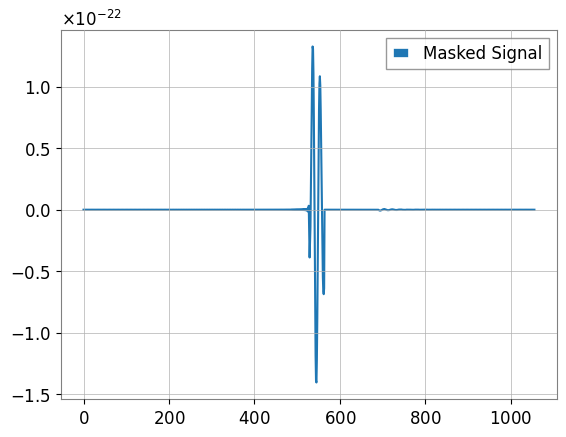

[ True  True  True ...  True  True  True]


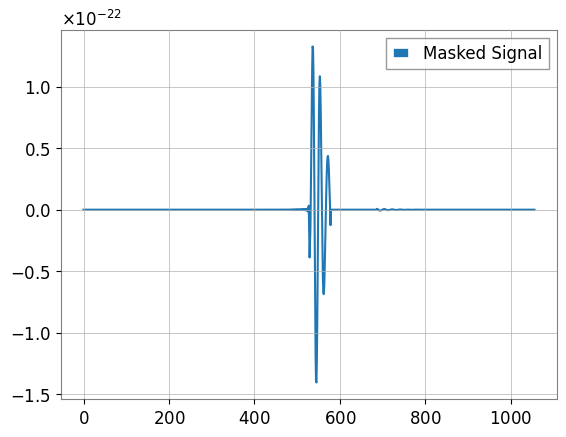

[ True  True  True ...  True  True  True]


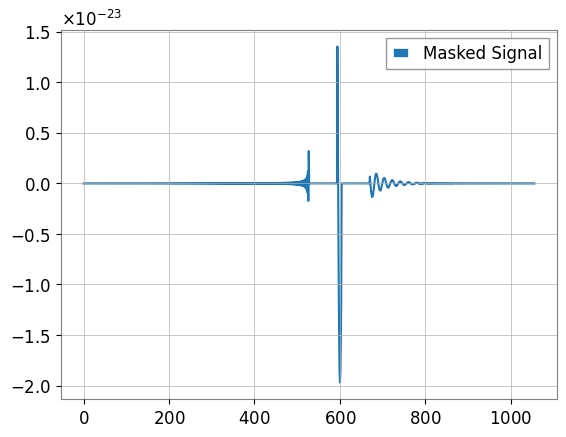

[ True  True  True ...  True  True  True]


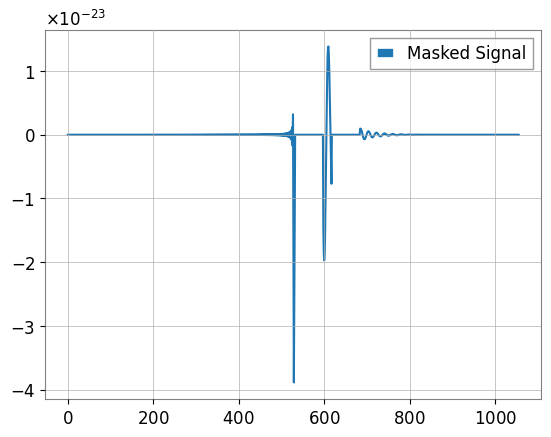

[ True  True  True ...  True  True  True]


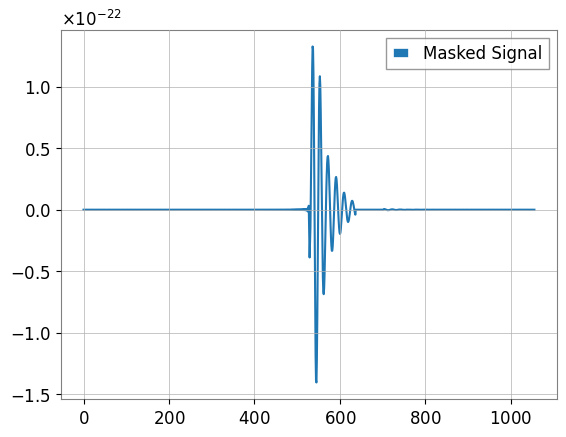

[ True  True  True ...  True  True  True]


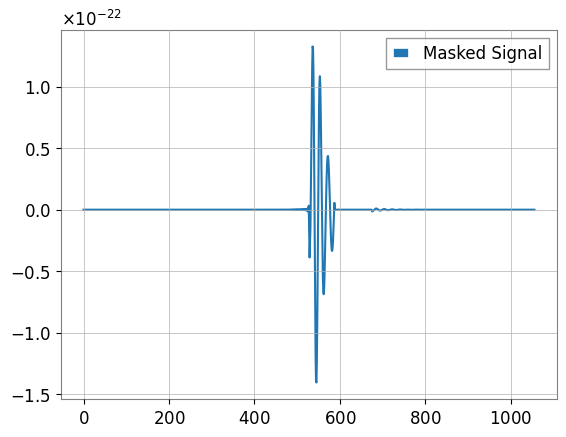

[ True  True  True ...  True  True  True]


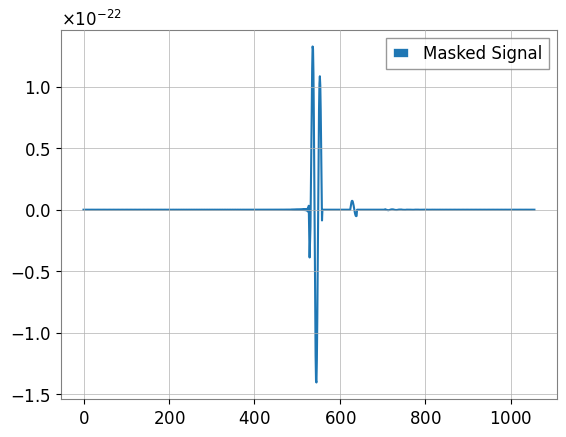

/tmp/ipykernel_1809682/27743682.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/torch/csrc/utils/tensor_new.cpp:274.)
  masked_signals = torch.tensor(masked_signals).float()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:

gap_size = signal_length//Config.signal_to_gap_length_ratio//2

masks =generate_continuous_mask(signals.shape[0], signal_length, gap_size,start=int(1/2*Config.signal_length))
masks2=generate_continuous_mask(signals.shape[0], signal_length, gap_size,start=int(1/2*Config.signal_length)+gap_size)
#     conditions.append(condition)
from utils.noise import *

#数据预处理

#gap_size = signal_length//Config.signal_to_gap_length_ratio

masked_signals = []
signals_copy=signals 
signals,_,_=normalize(signals)
for i in range(signals_copy.size(0)):
    masked_signal = np.copy(signals_copy[i])
    if np.random.rand() > 0.2:
        masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    #设置随机数
    if np.random.rand() > 0.2:
        masked_signal[~masks2[i].numpy()] = 0

    masked_signal[~masks2[i].numpy()]=0
    #绘制前几个masked信号
    if i< 10:
        print(masks[i].numpy())
        plt.plot(masked_signal, label='Masked Signal')
        plt.legend()
        plt.show()

    
    masked_signals.append(masked_signal)
masked_signals = torch.tensor(masked_signals).float()
masked_datas=masked_signals+noises
#masked_datas_copy,_,_=normalize(masked_datas)
whitened_masked_datas=[]
for i in range(signals_copy.size(0)):
    masked_data=np.copy(masked_datas[i])
    
    whitened_masked_data,_,_=whiten(masked_data, sample_rate=2,psd=psd_interp_func,highpass=2e-3)
    whitened_masked_datas.append(whitened_masked_data)
whitened_masked_datas,_,_=normalize(whitened_masked_datas)
processed_signals = []
processed_masked_datas = []
from model.QTranTimeMixerMod import *
from dataset.dataset import QSpecDataset
qt=QTransformModule()
Specs=[]


i=0
for Signal, masked_signal,masked_data in zip(signals, whitened_masked_datas,masked_datas):
    # 对原始信号进行小波变换和分段
    transformed_signal = wavelet_bandpass(Signal)
    segmented_signal = segment_signal(transformed_signal)
    
    # 对掩码信号进行小波变换和分段
    transformed_masked_signal = wavelet_bandpass(masked_signal)
    segmented_masked_signal = segment_signal(transformed_masked_signal)

    processed_signals.append(segmented_signal)
    processed_masked_datas.append(segmented_masked_signal)
    
    
    spec= qt(masked_data)
    Specs.append(spec)

    print(i)
    i+=1
    
print(1)







In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm  # 用于显示进度条
from dataset.dataset import QSpecDataset
from dataset.dataset import GWSignalDataset
from dataset.dataset import load_data_with_progress

def load_data_with_progress(dataset):
    # 使用 tqdm 显示进度条
    for idx in tqdm(range(len(dataset))):
        dataset[idx]

# 假设你的数据集已经加载到 `data` 变量中
# 例如 data = np.random.randn(10000, 256)
Spec_dataset = QSpecDataset(Specs)

# 加载数据并显示进度
load_data_with_progress(Spec_dataset)

dataset = GWSignalDataset(signals,masked_signals,processed_masked_datas, conditions)
#Spec_dataset=QSpecDataset(Specs)

100%|██████████| 10000/10000 [00:00<00:00, 1077368.68it/s]


加载数据进度: 0/10000
加载数据进度: 1000/10000
加载数据进度: 2000/10000
加载数据进度: 3000/10000
加载数据进度: 4000/10000
加载数据进度: 5000/10000
加载数据进度: 6000/10000
加载数据进度: 7000/10000
加载数据进度: 8000/10000
加载数据进度: 9000/10000


In [ ]:
print(Specs[0].shape)


torch.Size([2, 16, 264])


In [ ]:
import torch



# 保存 dataset
torch.save(dataset, '/home/ljq/code/Ringdown_gap_filling/Proj/dataset/train_dataset_noise_SNR5_gaps.pth')
torch.save(Spec_dataset, '/home/ljq/code/Ringdown_gap_filling/Proj/dataset/train_dataset_noise_SNR5_gaps_Spec.pth')

In [1]:
import torch
from dataset.dataset import *

dataset = torch.load('/home/ljq/code/Ringdown_gap_filling/Proj/dataset/train_dataset_noise_SNR5_gaps.pth')
Spec_dataset=torch.load('/home/ljq/code/Ringdown_gap_filling/Proj/dataset/train_dataset_noise_SNR5_gaps_Spec.pth')

dataset= CombinedDataset(dataset, Spec_dataset)


In [2]:
# 加载保存的 Dataset

import torch
import torch.nn 
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
#from model.mymodel_2 import MaskedConditionalGapFiller

from model.mymodel_4 import *
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#dataset=new_dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])




batch_size = Config.batch_size


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取一个批次的数据
targets,_,inputs, conditions,_ = next(iter(train_loader))

#打印形状
# print(f'Inputs shape: {inputs.shape}')  
# print(f'Targets shape: {targets.shape}')  
# print(f'Conditions shape: {conditions.shape}')  

import matplotlib.pyplot as plt

# 可视化第一个批次中的前几个样本
# num_samples_to_plot = 3  # 要绘制的样本数量
# for i in range(num_samples_to_plot):
#     plt.figure(figsize=(10, 4))
#     plt.plot(inputs[i].cpu().numpy(), label='Input (Masked)')
#     plt.plot(targets[i].cpu().numpy(), label='Target (Original)')
#     plt.title(f'Sample {i+1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Signal Value')
#     plt.legend()
#     plt.show()

/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [3]:
print(targets, inputs)

tensor([[ 1.4412, -1.4404,  1.4412,  ...,  1.4675, -1.4165,  1.4575],
        [-1.4317,  1.4354, -1.4317,  ..., -1.4647,  1.3995, -1.4641],
        [ 1.6244, -1.6241,  1.6244,  ...,  1.6389, -1.6006,  1.6507],
        ...,
        [-0.7007,  0.6994, -0.7007,  ..., -0.6483,  0.7576, -0.6394],
        [ 0.7339, -0.7326,  0.7339,  ...,  0.7625, -0.7092,  0.7487],
        [-1.3302,  1.3292, -1.3302,  ..., -1.2614,  1.3948, -1.2693]]) tensor([[[[-1.3743e-03,  3.6803e-05,  9.2307e-04,  ...,  1.2673e-05,
           -3.0300e-05,  2.7142e-05],
          [-1.9238e-05,  4.5906e-07,  1.7099e-05,  ...,  4.1389e-06,
            2.0553e-05, -4.9171e-05],
          [ 9.8472e-06, -3.6890e-05,  2.4299e-05,  ..., -3.6741e-05,
           -8.5182e-05,  9.6630e-05],
          ...,
          [-3.0286e-04,  2.3828e-04,  7.0642e-05,  ...,  4.8708e-05,
           -7.9115e-06, -1.9504e-05],
          [ 6.8769e-05, -1.2864e-04,  6.6490e-05,  ...,  1.1228e-05,
           -6.2299e-06, -9.0800e-06],
          [ 1.56

In [4]:

SAVE_PATH = '/home/ljq/code/Ringdown_gap_filling/Proj/saved_models/noise/lowSNR/model_with_noise_SNR5_gaps'
# 定义模型  
model = DenoiseMaskedGapsFiller().to(device)
train_the_model(
    model,
    train_loader,
    val_loader,
    num_epochs=Config.num_epochs,
    learning_rate=Config.learning_rate,
    save_path= SAVE_PATH,
    device=device,
    save_freq=10
)


/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


200
Epoch [1/200], Training Loss: 62.4328, Validation Loss: 63.0934
Epoch [2/200], Training Loss: 62.3856, Validation Loss: 63.0952
Epoch [3/200], Training Loss: 62.3848, Validation Loss: 63.0944
Epoch [4/200], Training Loss: 62.3822, Validation Loss: 63.0960
Epoch [5/200], Training Loss: 62.3826, Validation Loss: 63.0935
Epoch [6/200], Training Loss: 62.3793, Validation Loss: 63.0937
Epoch [7/200], Training Loss: 62.3776, Validation Loss: 63.0881
Epoch [8/200], Training Loss: 62.3815, Validation Loss: 63.0929
Epoch [9/200], Training Loss: 62.3779, Validation Loss: 63.0925
Epoch [10/200], Training Loss: 62.3782, Validation Loss: 63.0944
Model saved to /home/ljq/code/Ringdown_gap_filling/Proj/saved_models/noise/lowSNR/model_with_noise_SNR5_gaps_epoch_10
Epoch [11/200], Training Loss: 62.3775, Validation Loss: 63.0923
Epoch [12/200], Training Loss: 62.3770, Validation Loss: 63.0926
Epoch [13/200], Training Loss: 62.3773, Validation Loss: 63.0925
Epoch [14/200], Training Loss: 62.3761, Va

In [1]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 
 
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD





def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD

/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
import numpy as np
from config.config import Config
from data.waveform import *
from data.ringdown_waveform import Gap_dir as Ga
import torch
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils.psd import PSD_Lisa_no_Response
from utils.noise import *
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
from utils.SNR import compute_matched_filter_snr
import os
# def rotate_list(lst, position=2):
#     index = len(lst) // position
#     return lst[index:] + lst[:index]
SAVE_PATH_1= 'data/signal_data.npz'
SAVE_PATH_2 = 'data/signal_test_data.npz'
SAVE_PATH_noise= 'data/signal_data_with_noise.npz'
TEMP_DIR_1 = 'data/temp_files'
TEMP_DIR_2 = 'data/temp_files2'
os.makedirs(TEMP_DIR_1, exist_ok=True)  # 创建临时文件目录
scale=Config.scale
samp_freq=Config.samp_freq
N=round(samp_freq/Config.f_step)
time_vec=1/samp_freq*np.arange(0,N,1)
Noises=True
SNR=5
Paras=[1.1e5,1.2e5,0.9,1,4,6]
def generate_single_data(i):
    # 生成单个数据的代码
    Mtot=np.random.uniform(Paras[0],Paras[1])
    M_ratio=np.random.uniform(Paras[2],Paras[3])
    R_shift=np.random.uniform(Paras[4],Paras[5])
    # Mtot = np.random.uniform(Config.parameters[0], Config.parameters[1])
    # M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
    # R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
    signal_length = Config.signal_length

    para = [Mtot, M_ratio, R_shift]
    freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
    f_sf = sf(freq_ifft, para, para_dw, para_dtau)
    st = Ga.Freq_ifft(f_sf)*Config.zoom_factor

    if Noises:
        
        index = int(1/2*len(st))
        st=np.concatenate((st[index:], st[:index]))
        PSD=psd_interp_func(freq_ifft)
        out_noise, _ = generate_noise_from_psd(len(st),freq_ifft,PSD, sample_rate=samp_freq)
        
        #print(len(out_noise[0]))
        start1=int(1/2*(len(out_noise[0])-signal_length))
        start2=int(1/2*(len(st)-signal_length))
        #print(len(out_noise[0][start:start+signal_length]))
        signal = st[start2:start2+signal_length]
        signal=torch.tensor(signal)
        signal=torch.real(signal)
        
        noise=out_noise[0][start1:start1+signal_length]
        noise=torch.tensor(noise)
        noise=torch.real(noise)

        data=signal+noise
        return signal,noise,data,torch.from_numpy((np.array([Mtot, M_ratio, R_shift], dtype=np.float32)))

    else:
        original_signal = st[:signal_length]
        original_signal = torch.tensor(original_signal, dtype=torch.float32)
        original_signal = torch.real(original_signal)
        return original_signal, torch.from_numpy((np.array([Mtot, M_ratio, R_shift], dtype=np.float32)))

def generate_data(num_samples,TEMP_DIR, SAVE_PATH):
   
    """生成指定数量的样本数据，支持断点续传
    
    Args:
        num_samples: 需要生成的总样本数量
        
    Returns:
        Tuple: (signals, conditions) 全部样本数据
    """
    

    # 1. 初始化临时目录
    os.makedirs(TEMP_DIR, exist_ok=True)
    
    # 2. 准确计算已有样本数（忽略非样本文件）
    existing_samples = len([
        f for f in os.listdir(TEMP_DIR) 
        if f.startswith('sample_') and f.endswith('.npz')
    ])
    
    # 3. 计算需要生成的数量
    start_index = existing_samples
    remaining_samples = max(0, num_samples - start_index)
    
    # 4. 显示进度信息
    print(f"当前进度: {start_index}/{num_samples} | 待生成: {remaining_samples}")

    # 5. 生成缺失样本
    if remaining_samples > 0:
        try:
            with Pool(cpu_count()) as pool:
                results = tqdm(
                    pool.imap_unordered(generate_single_data, range(start_index, num_samples)),
                    #pool.imap_unordered(generate_single_data_with_noise, range(start_index, num_samples)),
                    total=remaining_samples,
                    desc="生成样本"
                )
                if Noises:
                    print('generate data with noise')
                    for i, (signal, noise, data, condition) in enumerate(results):
                        # 6. 实时保存每个样本
                        np.savez(
                            os.path.join(TEMP_DIR, f'sample_{start_index + i}.npz'),
                            signal=signal.numpy(),
                            noise=noise.numpy(),
                            data=data.numpy(),
                            condition=condition.numpy()
                        )
                else:
                    print('generate data without noise, SNR=',SNR)
                    for i, (signal, condition) in enumerate(results):
                        # 6. 实时保存每个样本
                        np.savez(
                            os.path.join(TEMP_DIR, f'sample_{start_index + i}.npz'),
                            signal=signal.numpy(),
                            condition=condition.numpy()
                    )
        except Exception as e:
            print(f"生成过程中出错: {str(e)}")
            raise RuntimeError("数据生成失败，请检查参数设置")
    
    # 7. 返回当前内存中的所有数据（可选）
    # 注意：对于大数据集建议使用 combine_data() 单独处理
    return combine_data(TEMP_DIR, SAVE_PATH)  # 或者 return None 仅执行生成操作

def combine_data(TEMP_DIR=TEMP_DIR_1, SAVE_PATH=SAVE_PATH_1):
    """合并所有样本数据并返回完整数据集"""
    try:
        # 获取并按序号排序样本文件
        sample_files = sorted(
            [f for f in os.listdir(TEMP_DIR) if f.startswith('sample_') and f.endswith('.npz')],
            key=lambda x: int(x.split('_')[1].split('.')[0])
        )
        
        if not sample_files:
            raise ValueError("未找到任何样本文件")
        if Noises:
            signals, noises,datas, conditions = [], [],[], []
            for f in tqdm(sample_files, desc="加载样本"):
                data = np.load(os.path.join(TEMP_DIR, f))
                signals.append(torch.tensor(data['signal']))
                noises.append(torch.tensor(data['noise']))
                datas.append(torch.tensor(data['data']))
                conditions.append(torch.tensor(data['condition']))
            
            # 合并数据
            signals = torch.stack(signals)
            noises = torch.stack(noises)
            datas = torch.stack(datas)
            # 修改 combine_data() 函数中的相关行：
            conditions = [c.reshape(3,1) if isinstance(c, torch.Tensor) else torch.tensor(c).reshape(3,1) for c in conditions]
            assert all(c.shape == conditions[0].shape for c in conditions), "形状仍不一致"
            conditions = torch.stack(conditions)
            
            # 保存完整数据集
            np.savez(SAVE_PATH, signals=signals.numpy(), noises=noises.numpy(),datas=datas.numpy(), conditions=conditions.numpy())
            print(f"已合并 {len(signals)} 个样本到 {SAVE_PATH}")
            
            return signals, noises,datas, conditions
        else:
            signals, conditions = [], []
            for f in tqdm(sample_files, desc="加载样本"):
                data = np.load(os.path.join(TEMP_DIR, f))
                signals.append(torch.tensor(data['signal']))
                conditions.append(torch.tensor(data['condition']))
            
            # 合并数据
            signals = torch.stack(signals)
            conditions = torch.stack(conditions)
            
            # 保存完整数据集
            np.savez(SAVE_PATH, signals=signals.numpy(), conditions=conditions.numpy())
            print(f"已合并 {len(signals)} 个样本到 {SAVE_PATH}")
            
            return signals, conditions
        
    except Exception as e:
        print(f"合并数据时出错: {str(e)}")
        raise

In [3]:
import torch
from config.config import Config
from utils.mask import generate_continuous_mask
import torch
from torch.utils.data import DataLoader
from config.config import Config
#from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_4 import DenoiseMaskedGapsFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform_with_noise
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 测试阶段

# def estimate_physical_parameters(signal):
signal_length=Config.signal_length
gap_size = signal_length//Config.signal_to_gap_length_ratio
model = DenoiseMaskedGapsFiller().to(device)
#model_path = '/home/ljq/code/Ringdown_gap_filling/Proj/saved_models/model.pth'
model.load_state_dict(torch.load('/home/ljq/code/Ringdown_gap_filling/Proj/saved_models/noise/lowSNR/model_with_noise_SNR5_gaps_1.pth'))

# 切换到评估模式
model.eval()

test_num=500
SAVE_PATH_test_noise = 'data/signal_test_data_with_noise_SNR5_gaps.npz'  
TEMP_DIR_test_noise= 'data/temp_test_gaps'  # 临时文件目录
#os.mkdir(TEMP_DIR_test_noise)  # 创建临时文件目录
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#清空临时目录
for f in os.listdir(TEMP_DIR_test_noise):
    os.remove(os.path.join(TEMP_DIR_test_noise, f))
# 重新创建临时目录
os.makedirs(TEMP_DIR_test_noise, exist_ok=True)  # 创建临时文件目录
# 生成测试集数据
test_signals,  noises,datas,test_conditions = generate_data(
        num_samples=test_num,TEMP_DIR=TEMP_DIR_test_noise,SAVE_PATH=SAVE_PATH_test_noise
    )
test_signals[0]=torch.zeros(signal_length)
print(test_signals.shape)
#masks=generate_continuous_mask(test_num,signal_length,gap_size,start=int(1/2*Config.signal_length))

test_signals = torch.tensor(test_signals, dtype=torch.float32)
masks = generate_continuous_mask(test_signals.size(0), signal_length, gap_size,start=int(1/2*Config.signal_length))
masks2=generate_continuous_mask(test_signals.size(0), signal_length, gap_size,start=int(1/2*Config.signal_length)+gap_size)
masked_signals = []
signals_copy=test_signals 
signals,mean,std=normalize(test_signals)
for i in range(signals_copy.size(0)):
    masked_signal = np.copy(signals_copy[i])
    if np.random.rand() > 0.2:
        masked_signal[~masks[i].numpy()] = 0
    if np.random.rand() > 0.2:
        masked_signal[~masks2[i].numpy()] = 0
    
    masked_signals.append(masked_signal)
masked_signals = torch.tensor(masked_signals, dtype=torch.float32).to(device)
noises = torch.tensor(noises, dtype=torch.float32).to(device)
masked_datas=masked_signals+noises

whitened_masked_datas=[]
for i in range(signals_copy.size(0)):
    masked_data=masked_datas[i]
    masked_data=masked_data.cpu().numpy()
    whitened_masked_data,_,_=whiten(masked_data, sample_rate=2,psd=psd_interp_func,highpass=2e-3)
    whitened_masked_data=torch.tensor(whitened_masked_data)
    whitened_masked_data=whitened_masked_data.to(device)
    whitened_masked_datas.append(whitened_masked_data)
whitened_masked_datas = torch.stack(whitened_masked_datas)

whitened_masked_datas,_,_=normalize(whitened_masked_datas)


processed_signals = []
processed_masked_datas = []
from model.QTranTimeMixerMod import *
qt=QTransformModule()
Specs=[]
i=0
for signal, masked_signal,masked_data in zip(signals, whitened_masked_datas,masked_datas):
    # 对原始信号进行小波变换和分段
    signal, masked_signal = signal.cpu(), masked_signal.cpu()
    transformed_signal = wavelet_bandpass(signal)
    segmented_signal = segment_signal(transformed_signal)

    # 对掩码信号进行小波变换和分段
    transformed_masked_signal = wavelet_bandpass(masked_signal)
    segmented_masked_signal = segment_signal(transformed_masked_signal)

    processed_signals.append(segmented_signal)
    processed_masked_datas.append(segmented_masked_signal)
    Spec= qt(masked_data.cpu())
    Specs.append(Spec)
    print(i)
    i+=1


processed_test_masked_signals_tensor = torch.tensor(processed_masked_datas, dtype=torch.float32).to(device)
Specs= torch.stack(Specs,dim=0)
Specs = torch.tensor(Specs, dtype=torch.float32).to(device)
std=std.cpu().numpy()
mean=mean.cpu().numpy()

当前进度: 0/500 | 待生成: 500


生成样本:   0%|          | 0/500 [00:00<?, ?it/s]

generate data with noise


加载样本: 100%|██████████| 500/500 [00:00<00:00, 2680.64it/s]
/tmp/ipykernel_41346/3385181074.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_signals = torch.tensor(test_signals, dtype=torch.float32)
/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)
/tmp/ipykernel_41346/3385181074.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/torch/csrc/utils/tensor_new.cpp:274.)
  masked_si

已合并 500 个样本到 data/signal_test_data_with_noise_SNR5_gaps.npz
torch.Size([500, 1056])


/tmp/ipykernel_41346/3385181074.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noises = torch.tensor(noises, dtype=torch.float32).to(device)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/tmp/ipykernel_41346/3385181074.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Specs = torch.tensor(Specs, dtype=torch.float32).to(device)


In [4]:
print(signals_copy.shape)

torch.Size([500, 1056])


In [5]:
print(std,mean)

[9.218930e-28 9.187956e-28 9.253986e-28 ... 9.378122e-28
 9.140542e-28 9.268600e-28] [-6.1994568e-27  6.1834138e-27 -6.2230309e-27 ... -6.2186256e-27
  6.2137664e-27 -6.1880780e-27]


In [6]:
print(noises)

tensor([[ 1.2220e-23, -1.4475e-24,  1.6370e-23,  ..., -4.9077e-24,
         -3.1110e-23,  3.0700e-23],
        [ 1.2220e-23, -1.4475e-24,  1.6370e-23,  ..., -4.9077e-24,
         -3.1110e-23,  3.0700e-23],
        [ 1.2220e-23, -1.4475e-24,  1.6370e-23,  ..., -4.9077e-24,
         -3.1110e-23,  3.0700e-23],
        ...,
        [ 7.1640e-24,  6.1890e-23,  5.3610e-23,  ...,  2.5234e-23,
          7.3935e-23,  5.1384e-23],
        [-4.1462e-23, -5.3353e-23, -2.9674e-23,  ...,  5.3817e-24,
         -3.6126e-23, -1.7769e-23],
        [ 2.8086e-23,  2.8389e-24, -1.2289e-23,  ...,  1.1436e-23,
          2.6929e-23, -1.7509e-23]], device='cuda:0')


In [7]:

with torch.no_grad():
    reconstructed_signals_tensor = model(processed_test_masked_signals_tensor,Specs)

In [52]:
num_check=65

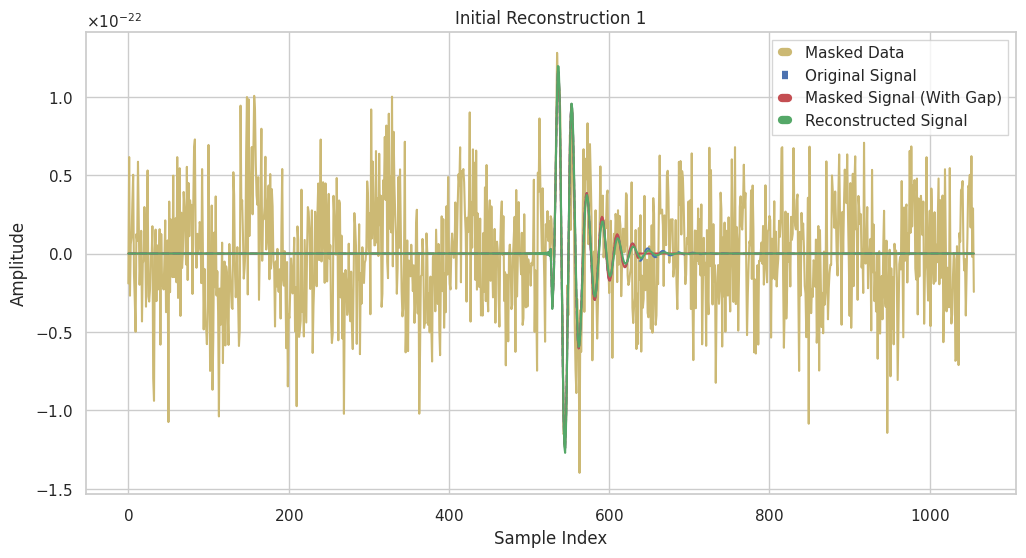

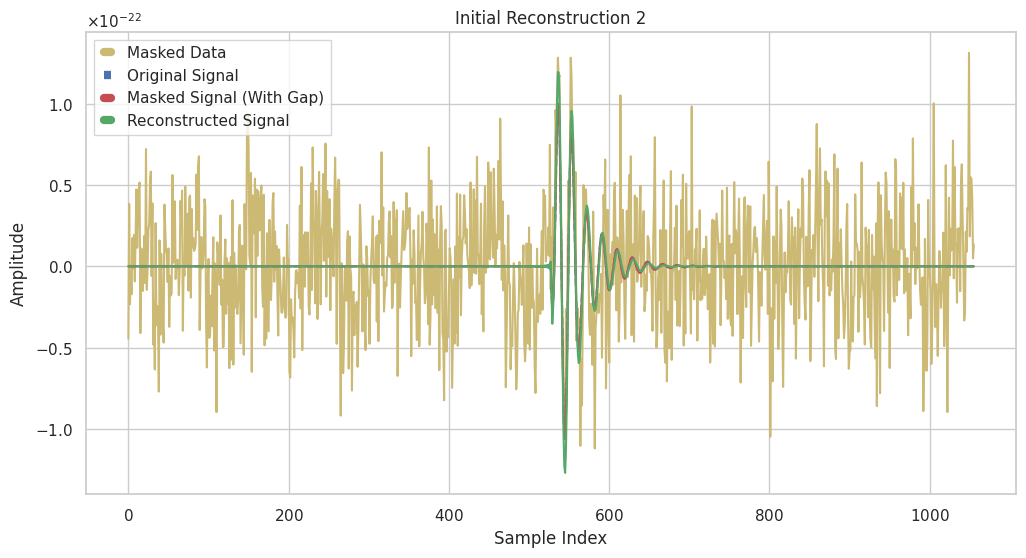

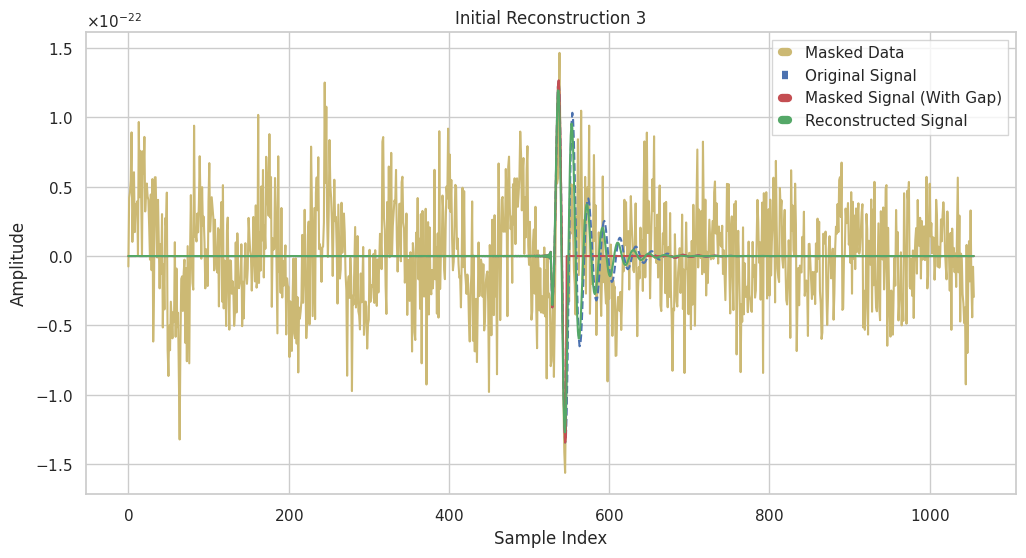

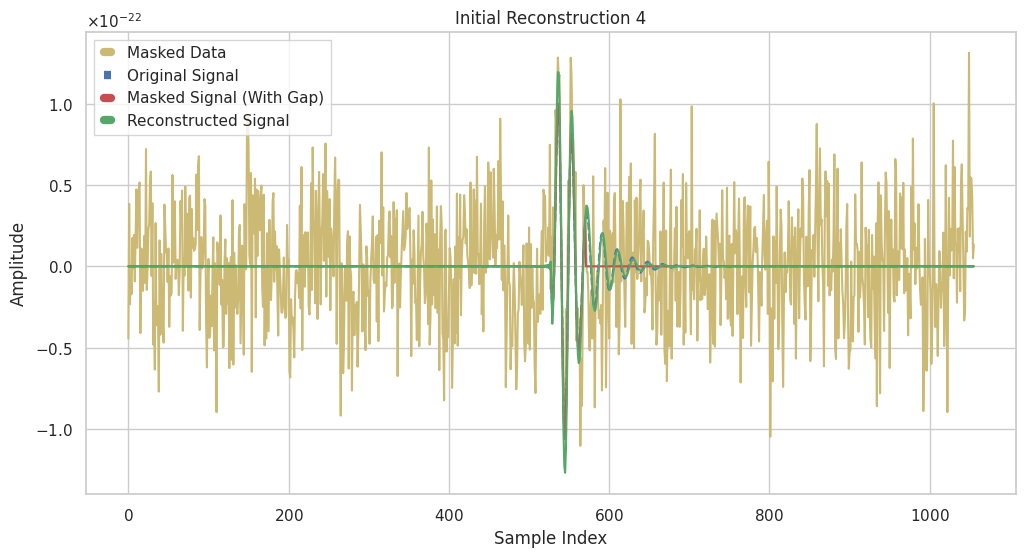

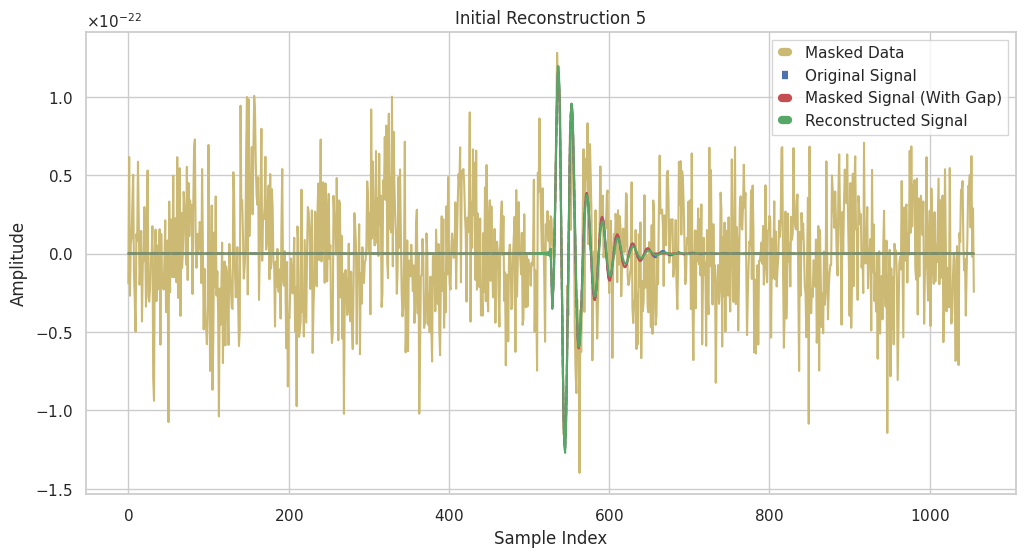

[-6.1953110e-27  6.1867691e-27 -6.2248756e-27 ... -6.2172031e-27
  6.2249203e-27 -6.1939629e-27]


In [53]:

#    initial_reconstructed_signals = mean_t+std_t*reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
# for i in range(5):
#     print(f"Signal {i}:")
#     print("Original signal contains NaN:", torch.isnan(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains NaN:", torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains NaN:", torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any())

#     print("Original signal contains Inf:", torch.isinf(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains Inf:", torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains Inf:", torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any())

#     # 如果没有NaN或者Inf，才进行可视化
#     if not (torch.isnan(torch.tensor(n_test_signals[i])).any() or
#             torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any() or
#             torch.isinf(torch.tensor(n_test_signals[i])).any() or
#             torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any()):
#         visualize_waveform(
#             n_test_signals[i],
#             masked_test_signals_tensor.cpu().numpy()[i],
#             initial_reconstructed_signals[i],
#             title=f'Initial Reconstruction {i+1}'
#         )
#     else:
#         print(f"Signal {i} contains NaN or Inf, skipping visualization.")
# for i in range(5):
#     print(f"Signal {i}:")
#     print(f"Original signal min: {n_test_signals[i].min()}, max: {n_test_signals[i].max()}")
#     print(f"Masked signal min: {masked_test_signals_tensor.cpu().numpy()[i].min()}, max: {masked_test_signals_tensor.cpu().numpy()[i].max()}")
#     print(f"Reconstructed signal min: {initial_reconstructed_signals[i].min()}, max: {initial_reconstructed_signals[i].max()}")
#print(masks.size(),test_signals.size())
#test_masked_signals=masks.cpu().numpy()*test_signals.cpu().numpy()
#print(masked_test_signals)
# 可视化初步复原结果

# print(type(test_signals.cpu().numpy()))
# masked_datas,masked_signals=masked_datas.cpu().numpy(),masked_signals.cpu().numpy()
for i in range(5):
    visualize_waveform_with_noise(
        masked_datas[i+num_check].cpu(),
        (signals_copy[i+num_check].cpu().numpy() ),
        masked_signals[i+num_check].cpu(),
        
        #noises[i].cpu(),
        reconstructed_signals_tensor.cpu().numpy()[i+num_check][0]*std+mean,
        title=f'Initial Reconstruction {i+1}'
        )
print(reconstructed_signals_tensor.cpu().numpy()[0][0]*std+mean-signals_copy[0].numpy())
# 参数估计
estimated_conditions = []
for i in range(reconstructed_signals_tensor.size(0)):
    estimated_params = test_conditions[i]
    estimated_conditions.append(estimated_params)
#estimated_conditions_tensor = torch.tensor(estimated_conditions, dtype=torch.float32).to(device)
estimated_conditions_tensor = torch.tensor(np.array(estimated_conditions), dtype=torch.float32).to(device)

# # 第二次复原：使用估计的条件输入
# with torch.no_grad():
#     final_reconstructed_signals_tensor = model(
#         test_signals_tensor,
#         masks,
#         estimated_conditions_tensor,  # 使用估计的条件输入
#         gap_start
#         )
#     final_reconstructed_signals = final_reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
#     final_reconstructed_signals= std_t*final_reconstructed_signals+mean_t
# # 可视化最终复原结果
# for i in range(5):
#     visualize_waveform(
#         test_signals[i],
#         masked_test_signals[i],
#         final_reconstructed_signals[i],
#         title=f'Final Reconstruction with Estimated Conditions {i+1}'
#         )

2


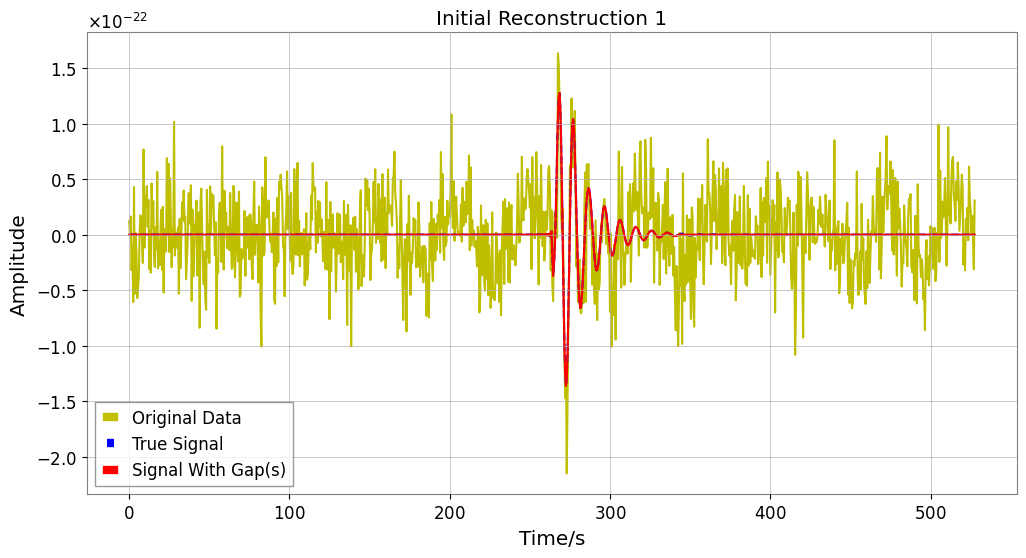

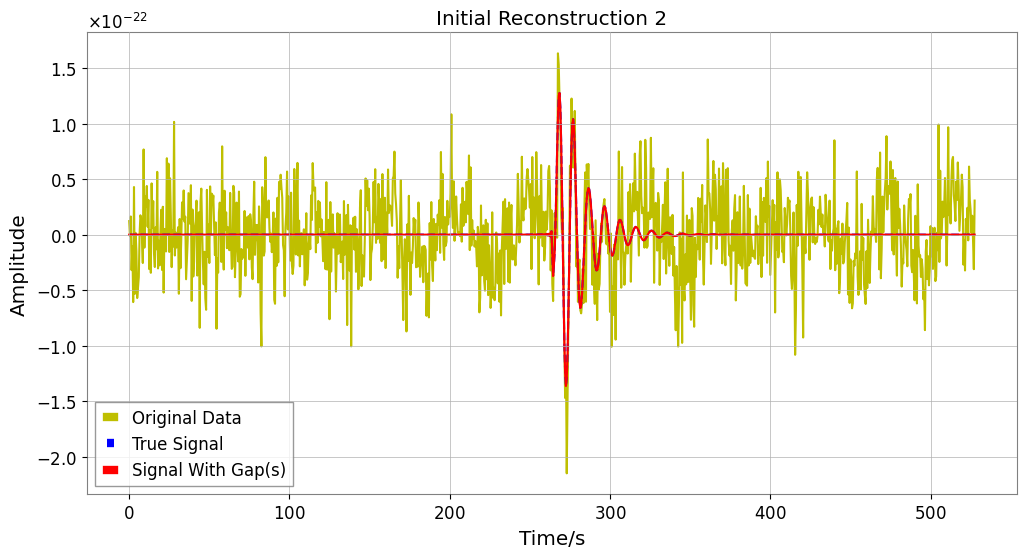

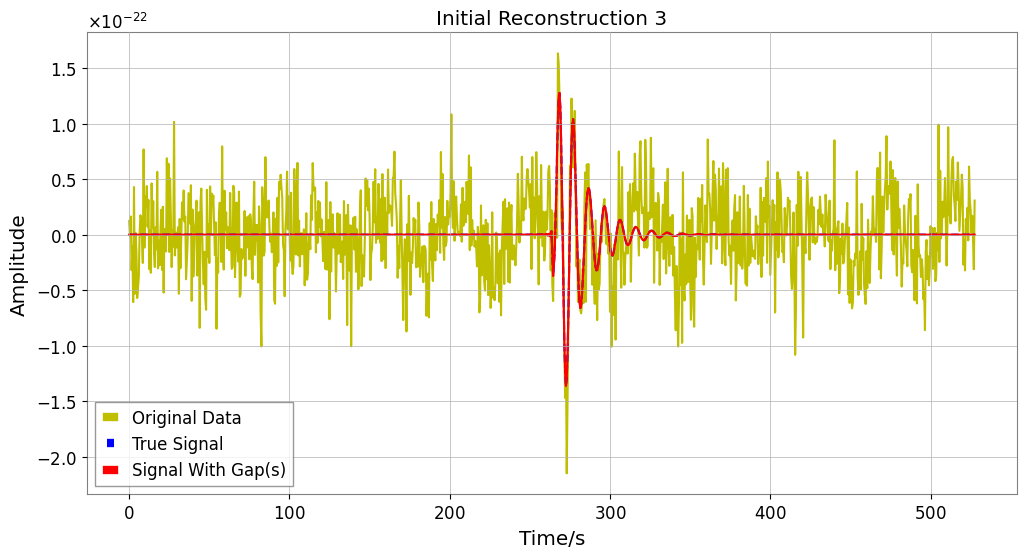

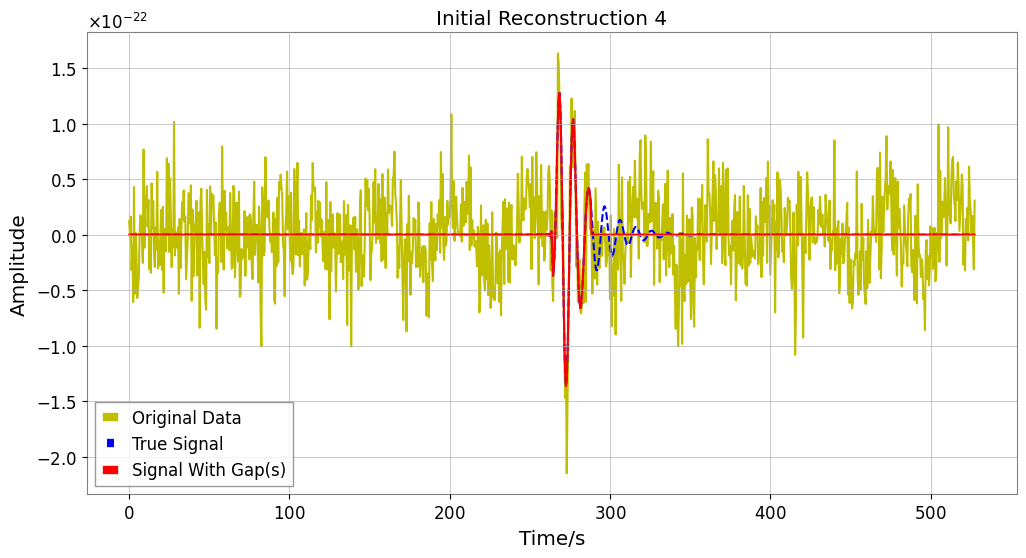

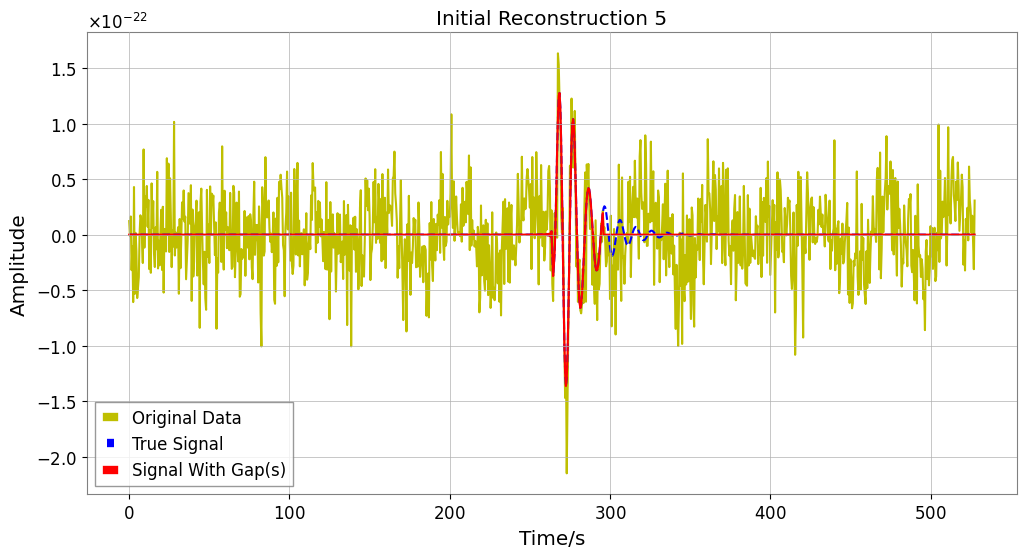

In [9]:
#绘图
def visualize_mod_1(time,masked_data,original_signal, masked_signal,  title='Waveform Reconstruction'):
    plt.figure(figsize=(12, 6))
    #黑色线绘制数据
    #plt.plot()
    plt.plot(time,masked_data, 'y-', label='Original Data')
    plt.plot(time,original_signal, 'b--', label='True Signal')
    plt.plot(time,masked_signal, 'r-', label='Signal With Gap(s)')
    
    #plt.plot(reconstructed_signal, 'g-', label='Reconstructed Signal')
    plt.xlabel('Time/s')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()
time=np.arange(0,len(masked_datas[0]))*1/Config.samp_freq
print(Config.samp_freq)
for i in range(5):
    visualize_mod_1(time,
        masked_datas[i+10].cpu(),
        (signals_copy[i+10].cpu().numpy() ),
        masked_signals[i+10].cpu(),
        
        #noises[i].cpu(),
        #reconstructed_signals_tensor.cpu().numpy()[i+10][0]*std+mean,
        title=f'Initial Reconstruction {i+1}'
        )

2
torch.Size([500, 1, 1056])


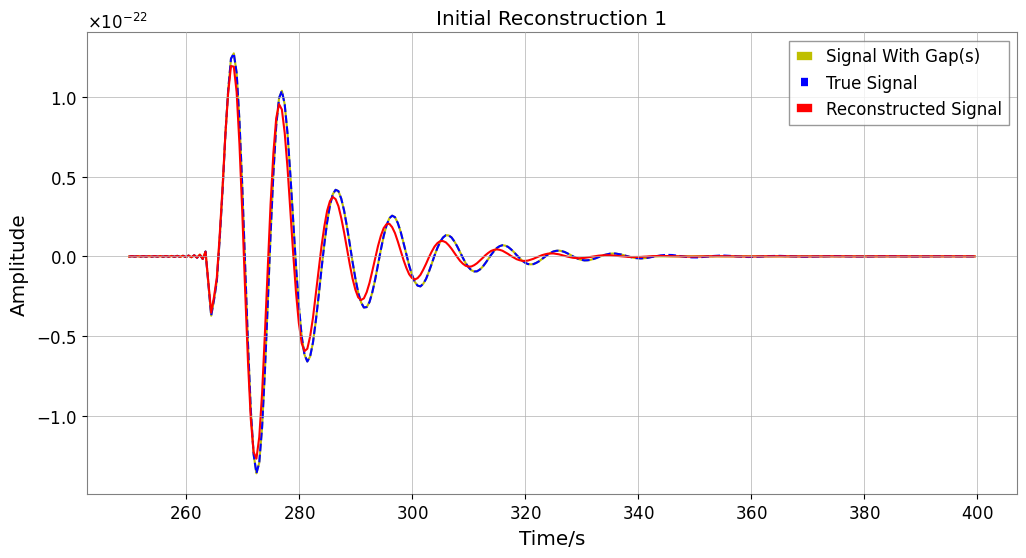

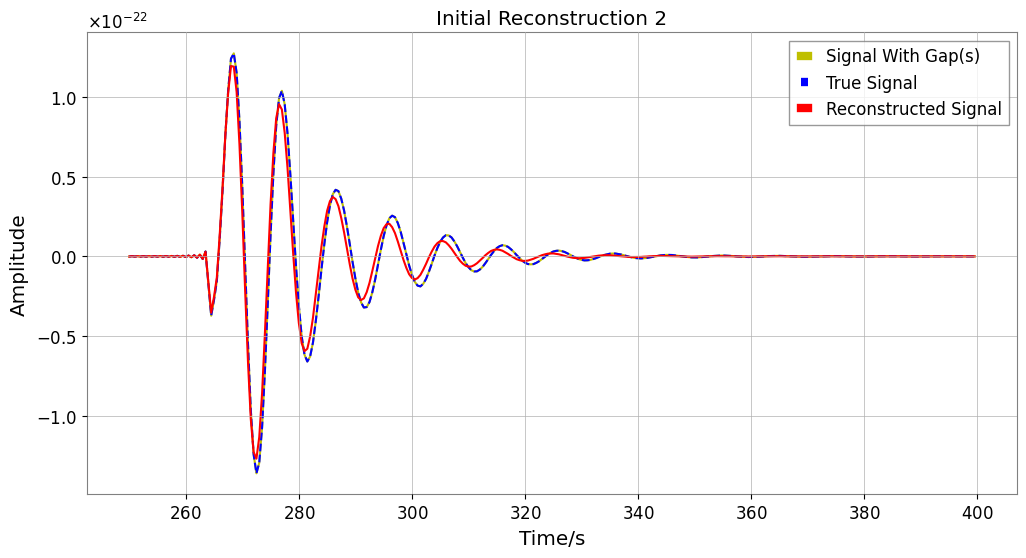

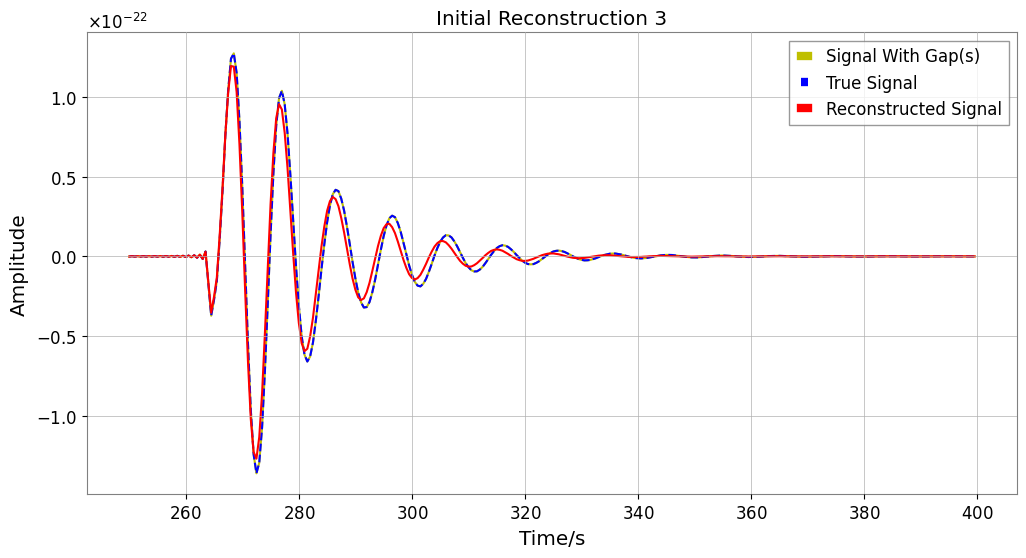

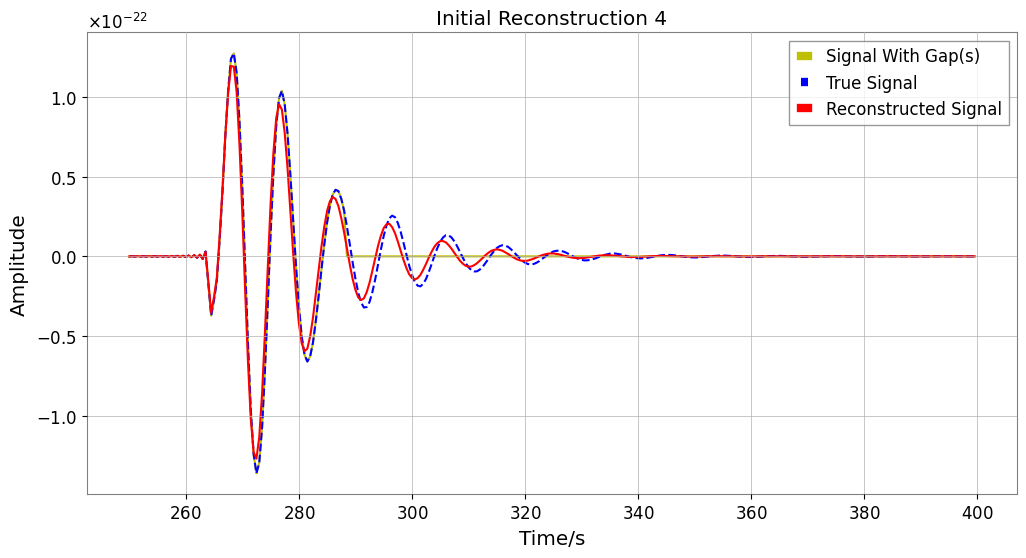

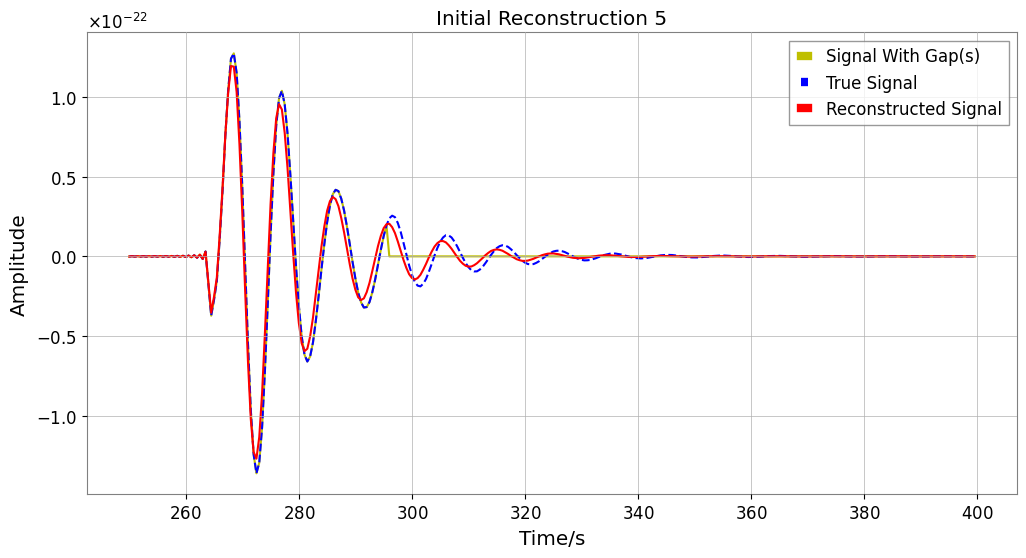

In [10]:
#绘图
def visualize_mod_1(time,original_signal, masked_signal,reconstructed_signal,  title='Waveform Reconstruction'):
    plt.figure(figsize=(12, 6))
    #黑色线绘制数据
    #plt.plot()
    
    plt.plot(time,original_signal, 'y-', label='Signal With Gap(s)')
    plt.plot(time,masked_signal, 'b--', label='True Signal')
    plt.plot(time,reconstructed_signal, 'r-', label='Reconstructed Signal')
    #plt.plot(reconstructed_signal, 'g-',r- label='Reconstructed Signal')
    plt.xlabel('Time/s')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()
time=np.arange(0,len(masked_datas[0]))*1/Config.samp_freq
print(Config.samp_freq)
print(reconstructed_signals_tensor.shape)
num_check=10
for i in range(5):
    visualize_mod_1(time[500:800],
        masked_signals[i+num_check][500:800].cpu(),
        (signals_copy[i+num_check][500:800].cpu().numpy() ),
        reconstructed_signals_tensor[i+num_check][0][500:800].cpu()*std[500:800]+mean[500:800],
        
        #noises[i].cpu(),
        #reconstructed_signals_tensor.cpu().numpy()[i+10][0]*std+mean,
        title=f'Initial Reconstruction {i+1}'
        )

In [11]:
#计算Miamatch
# 假设 orig 和 recon 为等长的一维numpy数组
orig= np.array(signals_copy[5].cpu().numpy())*1e20
print(signals.shape)
recon = np.array(reconstructed_signals_tensor.cpu().numpy()[5]*std+mean)*1e20
orig   = orig.astype(np.float64)
recon  = recon.astype(np.float64).squeeze(0)

inner = np.dot(orig, recon)                       
norms = np.linalg.norm(orig) * np.linalg.norm(recon)  # 范数乘积
norms = np.linalg.norm(orig) * np.linalg.norm(recon)
if norms == 0:
    match = 0.0
else:
    match = inner / norms
mismatch = 1 - match


mismatch = 1 - match                               # 失配度
print(mismatch)

torch.Size([500, 1056])
0.02012576686910561


In [12]:
print(test_conditions.shape)

torch.Size([500, 3, 1])


In [ ]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import hilbert
from scipy.stats import pearsonr

# 全局绘图风格设置
sns.set_theme(style="whitegrid")

# 数据准备：将 PyTorch 张量转换为 NumPy 数组，并反归一化重建信号
# 假设 std 和 mean 为归一化使用的标准差和均值（标量或与信号形状兼容的数组）
signals = signals_copy.cpu().numpy()           # 原始信号
reconstructed = reconstructed_signals_tensor.squeeze(1).cpu().numpy() * std + mean  # 重建信号反归一化
masked_signals_np = masked_signals.cpu().numpy()        # 含缺口的原始信号
masked_data_np = masked_datas.cpu().numpy()             # 含缺口+噪声的信号

# 可选：将 test_conditions 也转换为 NumPy 数组
try:
    conditions = test_conditions.cpu().numpy()
except:
    conditions = np.array(test_conditions)

# 查看数据形状确认
print("Original signals shape:", signals.shape)
print("Reconstructed signals shape:", reconstructed.shape)
print("Masked noisy signals shape:", masked_data_np.shape)


Original signals shape: (500, 1056)
Reconstructed signals shape: (500, 1056)
Masked noisy signals shape: (500, 1056)


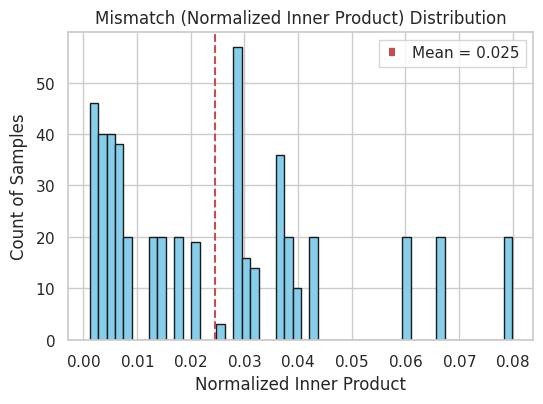

,Mismatch
count,499.000000
mean,0.024583
std,0.021151
min,0.001179
25%,0.005424
50%,0.020126
75%,0.036925
max,0.079924


In [ ]:
def compute_mismatch(original_signals, reconstructed_signals):
    """
    计算原始与重建信号的归一化内积（cosine 相似度）。
    返回每个样本的匹配值数组。
    """
    orig = np.array(original_signals)
    recon = np.array(reconstructed_signals)
    assert orig.shape == recon.shape, "原始和重建信号维度应相同"
    n_samples = orig.shape[0]
    mismatch_vals = []
    for i in range(n_samples):
        o = orig[i]*1e20
        r = recon[i]*1e20
        # 内积和范数
        dot_val = np.dot(o, r)
        #print(dot_val)
        norm_o = np.linalg.norm(o)
        norm_r = np.linalg.norm(r)
        #print(norm_r)
        if norm_o == 0 or norm_r == 0:
            # 若信号为空（范数为0），匹配度无法定义
            mismatch_vals.append(np.nan)
        else:
            match = dot_val / (norm_o * norm_r)  # 归一化内积
            mismatch_vals.append(1-match)
    return np.array(mismatch_vals)

# 计算 mismatch 数组
mismatch_values = compute_mismatch(signals, reconstructed)

# 绘制 mismatch 分布直方图
plt.figure(figsize=(6,4))
plt.hist(mismatch_values[~np.isnan(mismatch_values)], bins=50, color='skyblue', edgecolor='k')
plt.title("Mismatch (Normalized Inner Product) Distribution")
plt.xlabel("Normalized Inner Product")
plt.ylabel("Count of Samples")
plt.axvline(np.mean(mismatch_values[np.isfinite(mismatch_values)]), color='r', linestyle='--', label=f"Mean = {np.nanmean(mismatch_values):.3f}")
plt.legend()
plt.show()

# mismatch 数值统计摘要
mismatch_df = pd.DataFrame({"Mismatch": mismatch_values})
display(mismatch_df.describe())


[1.0263165e-07 1.0263165e-07 1.0263165e-07 ... 3.3790759e-08
 3.3233572e-08 1.4428201e-07]
[9.05961715e-05 9.05961715e-05 9.05961715e-05 ... 5.07502227e-05
 5.35248291e-05 1.03178325e-04]
[0.24177311 0.24177311 0.24177311 ... 0.07960212 0.07828954
 0.3398904 ]
[0.51802    0.51802    0.51802    ... 0.29018477 0.3060497
 0.5899635 ]


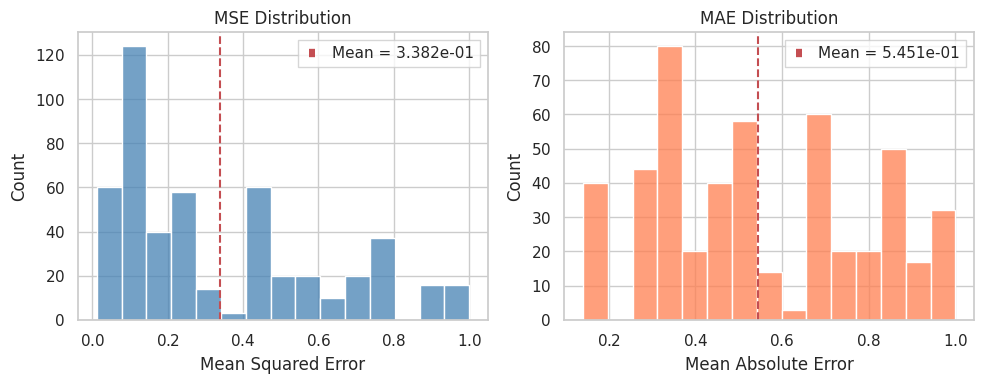

,count,mean,std,min,25%,50%,75%,max
MSE,498.0,0.338182,0.273480,0.012236,0.134645,0.248764,0.483623,1.0
MAE,498.0,0.545085,0.240469,0.140557,0.333230,0.518020,0.719203,1.0


In [ ]:
def compute_errors(original_signals, reconstructed_signals):
    """
    计算原始与重建信号之间的均方误差 (MSE) 和平均绝对误差 (MAE)。
    返回两个数组：每个样本的 MSE 列表和 MAE 列表。
    """
    orig = np.array(original_signals)*1e20
    recon = np.array(reconstructed_signals)*1e20
    assert orig.shape == recon.shape, "原始和重建信号维度应相同"
    # 计算差分
    diff = recon - orig
    mse_vals = np.mean(diff**2, axis=1)
    mae_vals = np.mean(np.abs(diff), axis=1)
    return mse_vals, mae_vals

# 计算每个样本的 MSE 和 MAE
mse_values, mae_values = compute_errors(signals[2:500], reconstructed[2:500])
#归一化value
print(mse_values)
print(mae_values)
mse_values = mse_values / np.max(mse_values)
mae_values = mae_values / np.max(mae_values)
print(mse_values)
print(mae_values)
# 绘制 MSE 和 MAE 分布直方图
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(mse_values, bins=15, color='steelblue', ax=axes[0])
axes[0].set_title("MSE Distribution")
axes[0].set_xlabel("Mean Squared Error")
axes[0].axvline(np.mean(mse_values), color='r', linestyle='--', label=f"Mean = {np.mean(mse_values):.3e}")
axes[0].legend()

sns.histplot(mae_values, bins=15, color='coral', ax=axes[1])
axes[1].set_title("MAE Distribution")
axes[1].set_xlabel("Mean Absolute Error")
axes[1].axvline(np.mean(mae_values), color='r', linestyle='--', label=f"Mean = {np.mean(mae_values):.3e}")
axes[1].legend()

plt.tight_layout()
plt.show()

# MSE 和 MAE 数值统计摘要
error_df = pd.DataFrame({"MSE": mse_values, "MAE": mae_values})
display(error_df.describe().T)


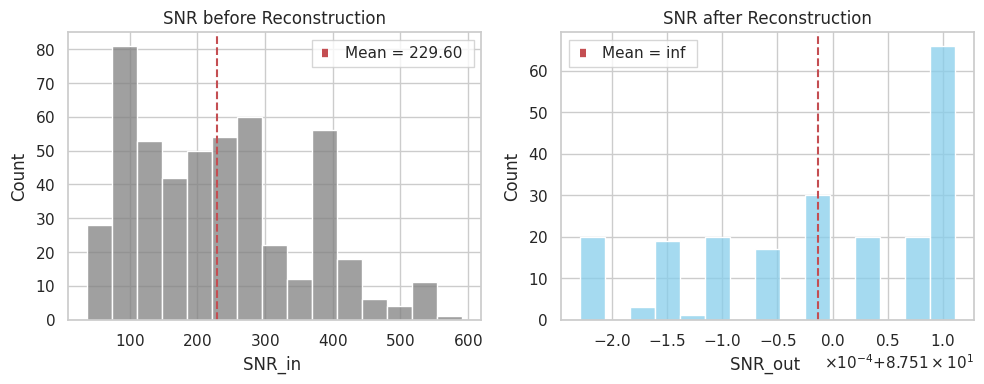

/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
SNR_in,498.0,229.60197,122.382139,37.120741,123.690228,217.903115,309.142027,592.180797
SNR_out,498.0,inf,NaN,87.509771,87.510027,NaN,NaN,inf
Improvement,498.0,inf,NaN,-504.670865,-87.358548,NaN,NaN,inf


In [ ]:
def compute_matched_filter_snr(s, h, PSD, samp_freq):
    N = len(s)
    df = samp_freq / N
    s_f = np.fft.fft(s)
    h_f = np.fft.fft(h)
    
    Sn = PSD[:N//2 + 1]
    numerator = s_f[:N//2 + 1] * np.conj(h_f[:N//2 + 1])
    matched_filter = 4 * numerator / Sn
    
    rho_t = np.fft.irfft(matched_filter, n=N)
    
    norm = np.sqrt(4 * np.sum(np.abs(h_f[:N//2 + 1])**2 / Sn) * df)
    rho_t /= norm
    
    return rho_t, np.max(np.abs(rho_t))
samp_freq=Config.samp_freq
PSD=lambda x: psd_interp_func(x)
def compute_snr(original_signals, observed_signals,psd,samp_freq):
    """
    计算每个样本的信噪比 (SNR) ，其中 original_signals 作为信号，observed_signals 作为含噪观测。
    SNR = 10 * log10( 信号功率 / 噪声功率 )。
    若无噪声误差则返回 inf，若无信号则返回 -inf。
    """
    N=len(original_signals[0])
    orig = np.array(original_signals)
    obs = np.array(observed_signals)
    
    assert orig.shape == obs.shape, "原始和观测信号维度应相同"
    snr_list = []
    for o, x in zip(orig, obs):
        signal_power = np.sum(o**2)
        noise_power = np.sum((x - o)**2)
        if noise_power == 0:
            snr = np.inf  # 无噪声误差
        elif signal_power == 0:
            snr = -np.inf  # 无信号
        else:
            df=samp_freq / N
            h_f= np.fft.fft(o)
            s_f= np.fft.fft(x)
            freq_ifft = np.fft.rfftfreq(len(h_f), d=1/samp_freq)
            PSD=psd(freq_ifft)
            Sn=PSD[:N//2 + 1]
            #print(len(Sn),len(PSD),len(freq_ifft))
            numerator = s_f[:N//2 + 1] * np.conj(h_f[:N//2 + 1])
            matched_filter = 4 * numerator / Sn
            rho_t = np.fft.irfft(matched_filter, n=N)
            
            norm = np.sqrt(4 * np.sum(np.abs(h_f[:N//2 + 1])**2 / Sn) * df)
            rho_t /= norm
            snr = np.max(np.abs(rho_t))
        snr_list.append(snr)
    return np.array(snr_list)




# 计算加入噪声前后的 SNR 数组
snr_in = compute_snr(signals[2:500], masked_data_np[2:500],PSD,Config.samp_freq)        # 噪声加入后的初始 SNR
snr_out = compute_snr(signals[2:500], reconstructed[2:500],PSD,Config.samp_freq)  # 模型重建后的 SNR
snr_improvement = snr_out - snr_in

# 绘制 SNR 分布对比直方图
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(snr_in[np.isfinite(snr_in)], color='gray', bins=15, ax=axes[0])
axes[0].set_title("SNR before Reconstruction")
axes[0].set_xlabel("SNR_in ")
axes[0].axvline(np.mean(snr_in[np.isfinite(snr_in)]), color='r', linestyle='--', label=f"Mean = {np.nanmean(snr_in):.2f} ")
axes[0].legend()

sns.histplot(snr_out[np.isfinite(snr_out)], color='skyblue', bins=15, ax=axes[1])
axes[1].set_title("SNR after Reconstruction")
axes[1].set_xlabel("SNR_out ")
axes[1].axvline(np.mean(snr_out[np.isfinite(snr_out)]), color='r', linestyle='--', label=f"Mean = {np.nanmean(snr_out):.2f} ")
axes[1].legend()

plt.tight_layout()
plt.show()

# SNR 提升统计摘要
snr_df = pd.DataFrame({
    "SNR_in": snr_in,
    "SNR_out": snr_out,
    "Improvement": snr_improvement
})
display(snr_df.describe().T)


/tmp/ipykernel_41346/106701456.py:96: RuntimeWarning: invalid value encountered in divide
  snr_sq = 4 * (np.sum(np.real(target_fft * ref_fft.conj()) / psd_interp))
/tmp/ipykernel_41346/106701456.py:96: RuntimeWarning: divide by zero encountered in divide
  snr_sq = 4 * (np.sum(np.real(target_fft * ref_fft.conj()) / psd_interp))
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))

KeyboardInterrupt



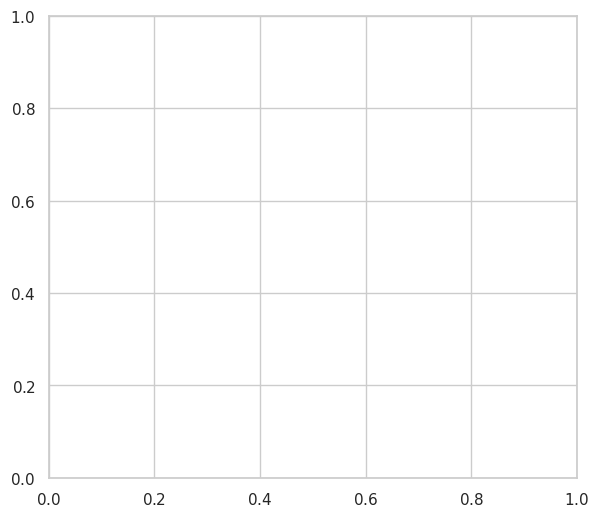

In [ ]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from scipy.signal.windows import tukey

# 假设的输入数据结构（根据您的描述）
# 真实原始信号 (500, N)
h_true = signals # 加载您的数据集 
# 含间隙噪声数据 (500, N)
h_gapped = masked_data_np
# 重建后的数据 (500, N)
h_recon = reconstructed
sample_rate = Config.samp_freq  # 根据实际情况修改
f_low = 1e-4  # 最低分析频率
f_high = 1e-1  # 最高分析频率

# %% [code] {"jupyter":{"outputs_hidden":false}}
def calculate_effective_segment(signal, gap_mask):
    """
    识别有效数据段，gap_mask是布尔掩码(0表示gap)
    返回有效段的起始和终止索引
    """
    edges = np.where(np.diff(gap_mask.astype(int)) != 0)[0] + 1
    if len(edges) == 0:
        return 0, len(signal)
    
    # 寻找最长连续有效段
    lengths = np.diff(np.concatenate(([0], edges, [len(signal)])))
    max_len = np.argmax(lengths[::2] if gap_mask[0] else lengths[1::2])
    
    if gap_mask[0]:
        start = edges[2*max_len] if max_len >0 else 0
        end = edges[2*max_len+1] if max_len>0 else edges[0]
    else:
        start = edges[2*max_len-1] if max_len>0 else 0
        end = edges[2*max_len] if max_len>0 else len(signal)
    
    return start, end

# %% [code] {"jupyter":{"outputs_hidden":false}}
from scipy import signal  # 确保正确导入信号处理模块

def compute_snr(h_target, h_ref, psd, flen=None, window='tukey'):
    """计算加权信噪比（完全基于Numpy实现）"""
    # -----------------数据预处理-----------------------
    # 通用张量转numpy方法（支持PyTorch/TensorFlow等框架）
    def to_array(data):
        if hasattr(data, 'numpy'):    # 支持TensorFlow/PyTorch
            return data.numpy()      
        elif hasattr(data, 'value'):  # 支持gwpy TimeSeries
            return data.value
        return np.asarray(data)
    
    target = to_array(h_target)
    ref = to_array(h_ref)
    
    # 确保数据类型为浮点型
    target = target.astype(np.float64)
    ref = ref.astype(np.float64)
    
    # -----------------信号对齐优化-----------------------
    if len(target) == len(ref):
        # 使用scipy的快速相关函数
        correlation = signal.correlate(target, ref, mode='same')
        peak_shift = np.argmax(correlation) - len(target)//2
        target = np.roll(target, peak_shift)
    
    # -------------FFT参数设置----------------------------
    N = len(target)
    fft_length = flen if flen else nextpow2(N)
    
    # 窗函数应用（直接作用在原始长度信号上）
    if window == 'tukey':
        win = signal.windows.tukey(N, alpha=0.25)
    else:
        win = np.ones(N)
    
    target_win = target * win
    ref_win = ref * win
    
    # ----------------PSD插值预处理-----------------------
    freqs = np.fft.rfftfreq(fft_length, 1/sample_rate)
    psd_interp = np.interp(freqs, 
                          psd.frequencies.value, 
                          psd.value,
                          left=psd.value[0], 
                          right=psd.value[-1])
    
    # -------------频谱计算-------------------------------
    target_fft = np.fft.rfft(target_win, n=fft_length)
    ref_fft = np.fft.rfft(ref_win, n=fft_length)
    
    # ------------SNR核心计算-----------------------------
    snr_sq = 4 * (np.sum(np.real(target_fft * ref_fft.conj()) / psd_interp)) 
    snr_sq *= sample_rate / fft_length
    return np.sqrt(np.abs(snr_sq))

def nextpow2(x):
    """计算最接近的2的幂次"""
    return 1 << (int(x) - 1).bit_length()



# %% [code] {"jupyter":{"outputs_hidden":false}}
# 基础PSD计算 (使用原始噪声)
noise_ts = TimeSeries(h_gapped[0] - h_true[0], sample_rate=sample_rate)
base_psd = noise_psd = noise_psd = noise_ts.psd(fftlength=4, overlap=2,
                                              method="median")

# 初始化存储变量
snr_before = np.zeros(500)
snr_after = np.zeros(500)
residual_psds = []

for i in range(500):
    # ---------------------- 预处理 ---------------------
    # 自动识别有效段
    gap_mask = ~np.isnan(h_gapped[i])  # 假设gap用NaN填充
    start= 500
    end= 1056
    # 截取有效段
    h_true_eff = h_true[i][start:end]
    h_gapped_eff = h_gapped[i][start:end]
    h_recon_eff = h_recon[i][start:end]
    
    # ----------------- SNR_before计算 -------------------
    # 使用原始PSD
    snr_before[i] = compute_snr(h_gapped_eff, h_true_eff, base_psd)
    
    # ----------------- SNR_after计算 --------------------
    # 计算残差噪声
    residual = h_recon_eff - h_true_eff
    
    # 估计新的PSD
    ts_res = TimeSeries(residual, sample_rate=sample_rate)
    res_psd = ts_res.psd(fftlength=4, overlap=2, method="median")
    residual_psds.append(res_psd)
    
    # 使用残差PSD计算新SNR
    snr_after[i] = compute_snr(h_recon_eff, h_true_eff, res_psd)

# 平均残差PSD
mean_res_psd = sum(residual_psds)/len(residual_psds)

# %% [code] {"jupyter":{"outputs_hidden":false}}
# 结果可视化
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.hist(snr_before, bins=30, alpha=0.5, label='Original (Gapped)')
plt.hist(snr_after, bins=30, alpha=0.5, label='Reconstructed')
plt.xlabel('SNR')
plt.ylabel('Count')
plt.legend()
plt.title('SNR Distribution Comparison')

plt.subplot(122)
plt.scatter(snr_before, snr_after, alpha=0.6)
plt.plot([0, max(snr_after)], [0, max(snr_after)], 'r--')
plt.xlabel('Original SNR')
plt.ylabel('Reconstructed SNR')
plt.title('SNR Improvement')
plt.grid(True)

plt.tight_layout()
plt.show()

# %% [code] {"jupyter":{"outputs_hidden":false}}
# 统计指标输出
print(f"平均SNR提升: {np.mean(snr_after - snr_before):.2f} ± {np.std(snr_after - snr_before):.2f}")
print(f"最大提升案例: {np.max(snr_after/snr_before):.1f}x")
print(f"PSD平均变化（高频部分）: {np.mean(mean_res_psd[f_high>base_psd.frequencies].value/base_psd[f_high>base_psd.frequencies].value):.2f} 倍")

# %% [code] {"jupyter":{"outputs_hidden":false}}
# 信噪比提升的时频分析可视化（示例事件）
idx = np.argmax(snr_after - snr_before)  # 选取提升最大的案例

plt.figure(figsize=(15,8))

# 原始含噪信号
ax1 = plt.subplot(311)
ts = TimeSeries(h_gapped[idx], sample_rate=sample_rate)
spec = ts.spectrogram(fftlength=2, overlap=1) ** (1/2.)
spec.plot(vmin=0.1, vmax=2)
plt.title(f'Original Signal (SNR={snr_before[idx]:.1f})')

# 重建信号
ax2 = plt.subplot(312, sharex=ax1)
ts = TimeSeries(h_recon[idx], sample_rate=sample_rate)
spec = ts.spectrogram(fftlength=2, overlap=1) ** (1/2.)
spec.plot(vmin=0.1, vmax=2)
plt.title(f'Reconstructed Signal (SNR={snr_after[idx]:.1f})')

# 残差噪声
ax3 = plt.subplot(313, sharex=ax1)
ts = TimeSeries(h_recon[idx]-h_true[idx], sample_rate=sample_rate)
spec = ts.spectrogram(fftlength=2, overlap=1) ** (1/2.)
spec.plot(vmin=0.1, vmax=2)
plt.title('Residual Noise')

plt.tight_layout()
plt.show()


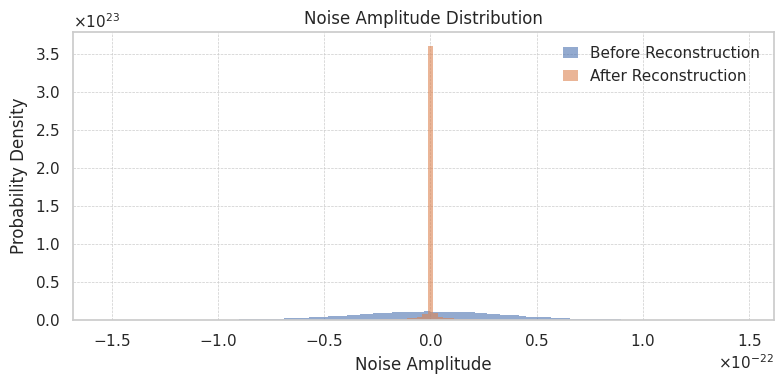

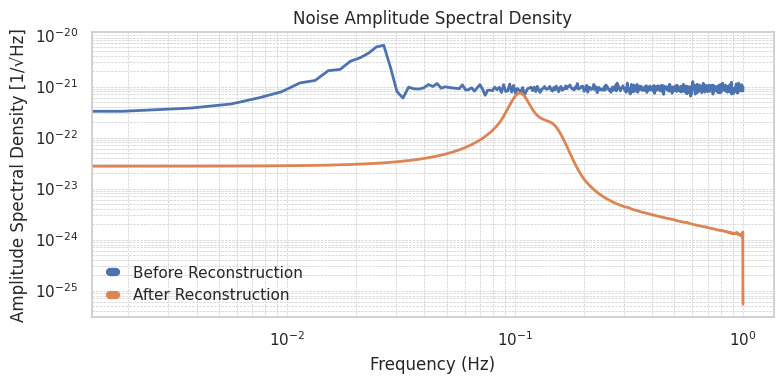

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 假设以下变量已在环境中定义：
# signals_copy, reconstructed_signals_tensor, masked_signals, masked_datas, test_conditions
# 以及重建时用到的 std, mean, 采样间隔 dt

# 转换到 numpy
signals = signals_copy.cpu().numpy()  # 原始信号 [50, 1056]
reconstructed = (reconstructed_signals_tensor.cpu().numpy() * std) + mean  # 重建后信号 [50, 1056]
reconstructed = reconstructed.squeeze(1)  # 去掉多余的维度
masked = masked_signals.cpu().numpy()  # 含 gap 的原始信号 [50, 1056]
data = masked_datas.cpu().numpy()  # 含 gap + 噪声的信号 [50, 1056]

# 定义噪声
noise_before = noises.cpu().numpy()  # 噪声 [50, 1056]
noise_after = reconstructed - signals

# 频谱计算参数
dt = 1/Config.samp_freq  # 采样间隔（秒），请根据实际数据调整
fs = 1.0 / dt
n = signals.shape[1]
freqs = np.fft.rfftfreq(n, d=dt)

# 计算平均幅度谱
fft_before = np.fft.rfft(noise_before, axis=1)
fft_after = np.fft.rfft(noise_after, axis=1)
amp_before = np.abs(fft_before).mean(axis=0)
amp_after = np.abs(fft_after).mean(axis=0)

# 绘制频谱对比
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(noise_before.flatten(), bins=100, density=True, alpha=0.6, label='Before Reconstruction', edgecolor='none')
ax.hist(noise_after.flatten(),  bins=100, density=True, alpha=0.6, label='After Reconstruction',  edgecolor='none')
ax.set_xlabel('Noise Amplitude')
ax.set_ylabel('Probability Density')
ax.set_title('Noise Amplitude Distribution')
ax.legend(frameon=False)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# 2) 噪声幅度谱密度（ASD）对比
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(freqs, amp_before, label='Before Reconstruction', linewidth=2)
ax.plot(freqs, amp_after,  label='After Reconstruction',  linewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude Spectral Density [1/√Hz]')
ax.set_title('Noise Amplitude Spectral Density')
ax.legend(frameon=False)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


(500, 1056) (500, 1056) (500, 1056)
(256,)


/tmp/ipykernel_41346/305104899.py:23: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmat = cwt(x, wavelet, scales)               # (scale_f, signal_length)
/tmp/ipykernel_41346/305104899.py:9: DeprecationWarning: scipy.signal.morlet2 is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = lambda M, s: morlet2(M, s, w=6.0)


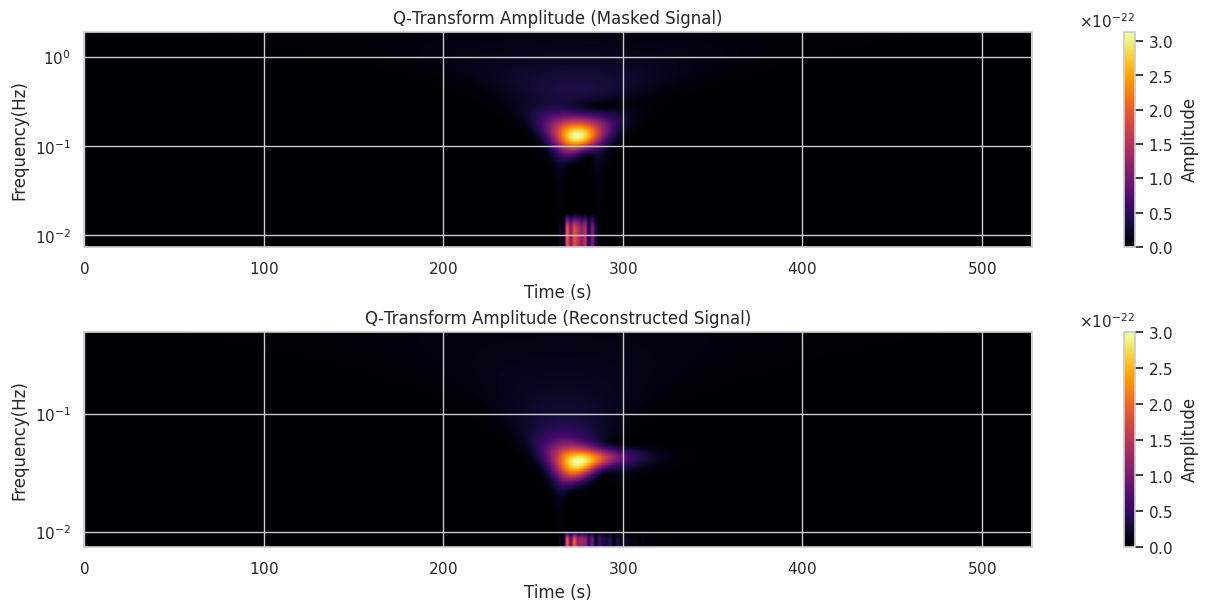

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, morlet2
from config.config import Config
# 1. 准备尺度和小波
scale_f = 256  # 小波变换的尺度数
scales = np.linspace(1, scale_f, num=scale_f)
# morlet2 参数：M=窗长，s=scale，w=6  
wavelet = lambda M, s: morlet2(M, s, w=6.0)
w = 6.0                 # 在 compute_q_spectrogram 里用了 morlet2 的 w=6
dt = 1/Config.samp_freq              # 采样间隔
f0 = w / (2*np.pi*dt)   # 中心频率
# 计算频率数组
freqs = f0 / scales     # shape (scale_f,)

# 计算谱图（同前）

# 2. 定义一个函数，对单条一维信号做 Q‑transform (CWT)

def q_spectrogram(x):
    # x: 1D numpy array, shape (signal_length,)
    # 批量支持：如果传入 2D array (batch, length)，scipy.cwt 会返回 (batch, scales, length)
    cwtmat = cwt(x, wavelet, scales)               # (scale_f, signal_length)
    cwtmat = cwtmat[:, ::down_samp]                 # 时间下采样
    return np.abs(cwtmat)                          # 返回振幅谱, shape (scale_f, time_steps)

# 3. 取出要展示的第一条信号
signals = signals_copy.cpu().numpy()  # 原始信号 [50, 1056]
reconstructed = (reconstructed_signals_tensor.cpu().numpy() * std) + mean  # 重建后信号 [50, 1056]
reconstructed = reconstructed.squeeze(1)  # 去掉多余的维度
masked = masked_signals.cpu().numpy()  # 含 gap 的原始信号 [50, 1056]
data = masked_datas.cpu().numpy()  # 含 gap + 噪声的信号 [50, 1056]
print(masked.shape,data.shape,reconstructed.shape)
sig_mask = masked[1]     # 第一条 gap 信号
sig_recon = reconstructed[1]     # 第一条重建信号

# 4. 计算它们的谱图
spec_mask = q_spectrogram(sig_mask)
spec_recon = q_spectrogram(sig_recon)

# 5. 绘图
fig, axes = plt.subplots(2, 1, figsize=(12, 6), constrained_layout=True)
print(freqs.shape)
# Masked 信号热图
t_max = sig_mask.shape[0] * dt
time_extent = np.linspace(0, t_max, spec_mask.shape[1])
axes[0].imshow(
    spec_mask,
    origin='lower',
    aspect='auto',
    cmap='inferno',
    extent=[0, t_max, freqs.min(), freqs.max()]
)
axes[0].set_title('Q‑Transform Amplitude (Masked Signal)')
axes[0].set_ylabel('Frequency(Hz)')
axes[0].set_yscale('log')
axes[0].set_xlabel('Time (s)')
fig.colorbar(axes[0].images[0], ax=axes[0], label='Amplitude')

# Reconstructed 信号热图
axes[1].imshow(
    spec_recon,
    origin='lower',
    aspect='auto',
    cmap='inferno',
    extent=[0, t_max, freqs.min(), freq.max()]
)


axes[1].set_title('Q‑Transform Amplitude (Reconstructed Signal)')
axes[1].set_ylabel('Frequency(Hz)')
axes[1].set_yscale('log')
axes[1].set_xlabel('Time (s)')
fig.colorbar(axes[1].images[0], ax=axes[1], label='Amplitude')

plt.show()


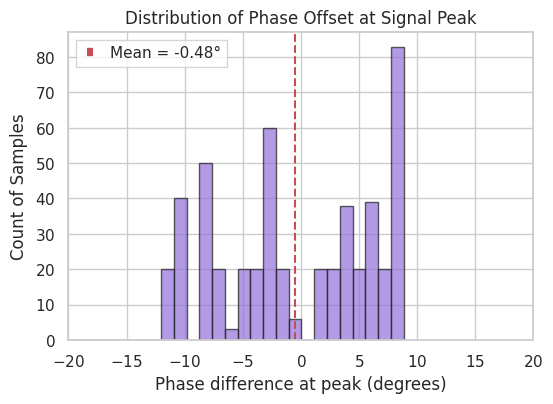

(500,)
平均峰值处相位差: 0.1075 弧度 (6.16°)
各样本平均相位差的均值: 0.1598 弧度 (9.16°)


In [46]:
def analyze_phase_difference(original_signals, reconstructed_signals):
    """
    利用 Hilbert 变换分析原始与重建信号的相位差异。
    返回两个数组：peak_phase_diffs（各样本峰值处的相位差），mean_abs_phase_diffs（各样本平均相位差的绝对值）。
    单位为弧度。
    """
    orig = np.array(original_signals)
    recon = np.array(reconstructed_signals)
    assert orig.shape == recon.shape, "原始和重建信号维度应相同"
    peak_phase_diffs = []
    mean_abs_phase_diffs = []
    for o, r in zip(orig, recon):
        # Hilbert 解析信号和瞬时相位
        phase_o = np.unwrap(np.angle(hilbert(o)))
        phase_r = np.unwrap(np.angle(hilbert(r)))
        phase_diff = phase_r - phase_o
        # 将相位差限制在 [-pi, pi] 区间（去除2π模糊）
        phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
        # 峰值处相位差
        peak_idx = np.argmax(np.abs(hilbert(o)))
        peak_phase_diffs.append(phase_diff[peak_idx])
        # 平均绝对相位差
        mean_abs_phase_diffs.append(np.mean(np.abs(phase_diff)))
    return np.array(peak_phase_diffs), np.array(mean_abs_phase_diffs)
masked = masked_signals.cpu().numpy()  # 含 gap 的原始信号 [50, 1056]
signals = signals_copy.cpu().numpy()  # 原始信号 [50, 1056]
reconstructed = (reconstructed_signals_tensor.cpu().numpy() * std) + mean  # 重建后信号 [50, 1056]
reconstructed = reconstructed.squeeze(1)  # 去掉多余的维度
masked = masked_signals.cpu().numpy()  # 含 gap 的原始信号 [50, 1056]
data = masked_datas.cpu().numpy()  # 含 gap + 噪声的信号 [50, 1056]
# 计算相位偏移指标
peak_phase_diffs, mean_abs_phase_diffs = analyze_phase_difference(signals, reconstructed)
# 以度为单位计算峰值相位差便于直观展示
peak_phase_diffs_deg = peak_phase_diffs * 180/np.pi

# 峰值处相位差分布直方图（度）
plt.figure(figsize=(6,4))
plt.hist(peak_phase_diffs_deg, bins=100, color='mediumpurple', edgecolor='k', alpha=0.7)
plt.xlabel("Phase difference at peak (degrees)")
plt.ylabel("Count of Samples")
plt.title("Distribution of Phase Offset at Signal Peak")
plt.axvline(np.mean(peak_phase_diffs_deg), color='r', linestyle='--', label=f"Mean = {np.mean(peak_phase_diffs_deg):.2f}°")
#设置x轴的范围在0附近
plt.xlim(-20, 20)
plt.legend()
plt.show()
print(peak_phase_diffs.shape)
# 相位偏移数值统计
avg_peak_phase_diff = np.mean(np.abs(peak_phase_diffs))      # 平均峰值处相位偏移（绝对值平均）
avg_mean_phase_diff = np.mean(mean_abs_phase_diffs)          # 平均相位差（各样本平均绝对相位差的均值）
print(f"平均峰值处相位差: {avg_peak_phase_diff:.4f} 弧度 ({avg_peak_phase_diff*180/np.pi:.2f}°)")
print(f"各样本平均相位差的均值: {avg_mean_phase_diff:.4f} 弧度 ({avg_mean_phase_diff*180/np.pi:.2f}°)")
